# Normalize S2 data using NEON as a reference
step1: prepare S2 data: open S2 safe file in PCI and open 20m bands and export to a tiff file (PCI inlcuding 10m B2,3,4 in 20m as well) (not in the code)<br>
step2: subset 20m S2 using NEON 10m band as a reference using PCI<br>
step3: using GDAL the resampling method to generate 60m data for S2 and NEON in order to smooth the images<br>
step4: using NEON 60m data as the reference and S2 as input to generate linear coefficents using stats.theilslopes<br>
step5: read S2 20m file and normalizing and genereate 20m normalized S2<br>
step6: generate a 20m NEON data using GDAL average resamling method for the comparsion of the normalized S2<br>
step7: verify the normalized result through ploting normalized S2 and NEON 20,  RMSE, SSIM and R2_score.<br>
Next step: using DSen2 to process normalized S2 data (Not Done)

In [ ]:
# from scipy import interpolate
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score

In [80]:
S2_file='F:\\neon\\normalization\\S2_20m_ABBY.tif'
S2_file_60m='F:\\neon\\normalization\\S2_60m_ABBY.tif'

In [81]:
# generate 60m S2 data
raster_rprj = gdal.Warp(S2_file_60m, S2_file, xRes=60, yRes=60, resampleAlg = "average")
raster_rprj = None

In [82]:
NEON_file='F:\\neon\\normalization\\NEON_D16_ABBY_DP1_20210719_191207_reflectance_10m.tif'
NEON_file_60m='F:\\neon\\normalization\\NEON_60m_ABBY.tif'
NEON_file_20m='F:\\neon\\normalization\\NEON_20m_ABBY.tif'

In [83]:
# generate 60m NEON data
raster_rprj = gdal.Warp(NEON_file_60m, NEON_file, xRes=60, yRes=60, resampleAlg = "average")
raster_rprj = None

In [84]:
ds_S2_60m = gdal.Open(S2_file_60m)
ds_NEON_60m = gdal.Open(NEON_file_60m)
print (ds_S2_60m.RasterCount)
print (ds_NEON_60m.RasterCount)
print (ds_S2_60m.GetDescription())
print (ds_NEON_60m.GetDescription())

9
16
F:\neon\normalization\S2_60m_ABBY.tif
F:\neon\normalization\NEON_60m_ABBY.tif


In [85]:
bands_S2 = {ds_S2_60m.GetRasterBand(i).GetDescription(): i for i in range(1, ds_S2_60m.RasterCount + 1)}
bands_NEON = {ds_NEON_60m.GetRasterBand(i).GetDescription(): i for i in range(1, ds_NEON_60m.RasterCount + 1)}
print (bands_S2)
print (bands_NEON)

{'Sentinel-2 Blue (0.457 - 0.523) um': 1, 'Sentinel-2 Green (0.542 - 0.578) um': 2, 'Sentinel-2 Red (0.650 - 0.680) um': 3, 'Sentinel-2 Vegetation Red Edge 1 (0.697 - 0.713) um': 4, 'Sentinel-2 Vegetation Red Edge 2 (0.732 - 0.748) um': 5, 'Sentinel-2 Vegetation Red Edge 3 (0.773 - 0.793) um': 6, 'Sentinel-2 NIR (0.855 - 0.875) um': 7, 'Sentinel-2 SWIR-1 (1.565 - 1.655) um': 8, 'Sentinel-2 SWIR-2 (2.100 - 2.280) um': 9}
{'': 16}


In [ ]:
# S2 1-B2 2-B3 3-B4 4-B5 5-B6 6-B7 7-B8A 8-B11 9-B12<br>
# NEON 1-B1 2-B2, 3-B3, 4-B4 5-B5 6-B6 7-B7 8-B8 9-B8A 10-B9 11-B10 12-B11 13-B12

# band by band to generate linear regression coefficents and check the stats for each band 

In [86]:
#B3
S2_B3=np.array(ds_S2_60m.GetRasterBand(2).ReadAsArray())
NEON_B3=np.array(ds_NEON_60m.GetRasterBand(3).ReadAsArray())

S2_B3 = np.where(S2_B3==-9999, np.nan, S2_B3)
NEON_B3 = np.where(NEON_B3==-9999, np.nan, NEON_B3)
S2_B3=S2_B3/10000

mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
NEON_B3_mask = NEON_B3[mask]
S2_B3_mask = S2_B3[mask]
# scipy.stats.theilslopes(y, x=None, alpha=0.95, method='separate')
# Method to be used for computing estimate for intercept. Following methods are supported,
# ‘joint’: Uses np.median(y - slope * x) as intercept.
# ‘separate’: Uses np.median(y) - slope * np.median(x) as intercept.
# The default is ‘separate’.
# B3_reg = stats.theilslopes(S2_B3_mask, NEON_B3_mask, 0.90, 'joint')
B3_reg = stats.theilslopes(NEON_B3_mask,S2_B3_mask, 0.90, 'joint')

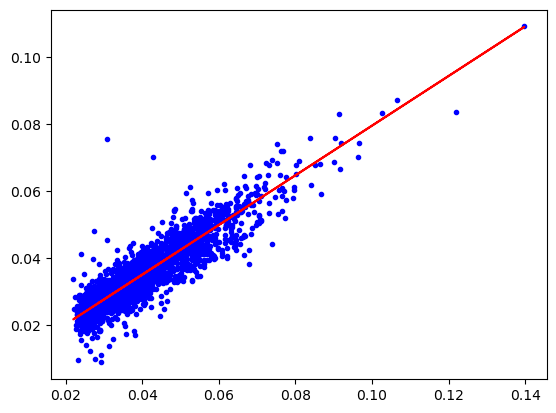

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B3_mask,NEON_B3_mask, 'b.')
ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [88]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [89]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B3_mask,S2_B3_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B3_mask,S2_B3_mask,data_range=(S2_B3_mask.max()-S2_B3_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B3_mask,S2_B3_mask)
print (RMSE)
print (SSIM)
print (R2)

0.007638421933527067
0.7995726563463907
0.4295820630709777


In [90]:
# print (rmse(S2_B3_mask, NEON_B3_mask))
# print (mean_squared_error(S2_B3_mask, NEON_B3_mask, squared=False) )

In [91]:
#B4
S2_B4=np.array(ds_S2_60m.GetRasterBand(3).ReadAsArray())
NEON_B4=np.array(ds_NEON_60m.GetRasterBand(4).ReadAsArray())

S2_B4 = np.where(S2_B4==-9999, np.nan, S2_B4)
NEON_B4 = np.where(NEON_B4==-9999, np.nan, NEON_B4)
S2_B4=S2_B4/10000

mask = ~np.isnan(S2_B4) & ~np.isnan(NEON_B4)
NEON_B4_mask = NEON_B4[mask]
S2_B4_mask = S2_B4[mask]
B4_reg = stats.theilslopes(NEON_B4_mask,S2_B4_mask, 0.90, 'joint')

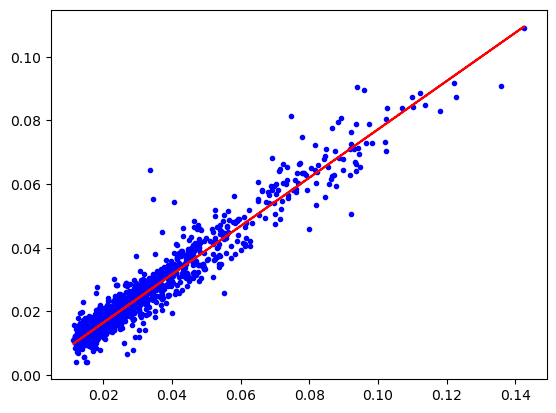

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(  S2_B4_mask,NEON_B4_mask, 'b.')
ax.plot(  S2_B4_mask,B4_reg[1] +B4_reg[0] * S2_B4_mask, 'r-')
plt.show()

In [93]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B4_mask,S2_B4_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B4_mask,S2_B4_mask,data_range=(S2_B4_mask.max()-S2_B4_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B4_mask,S2_B4_mask)
print (RMSE)
print (SSIM)
print (R2)

0.006927515953884244
0.8793516548335826
0.7232725572341359


In [94]:
#B5
S2_B5=np.array(ds_S2_60m.GetRasterBand(4).ReadAsArray())
NEON_B5=np.array(ds_NEON_60m.GetRasterBand(5).ReadAsArray())

S2_B5 = np.where(S2_B5==-9999, np.nan, S2_B5)
NEON_B5 = np.where(NEON_B5==-9999, np.nan, NEON_B5)
S2_B5=S2_B5/10000

mask = ~np.isnan(S2_B5) & ~np.isnan(NEON_B5)
NEON_B5_mask = NEON_B5[mask]
S2_B5_mask = S2_B5[mask]
B5_reg = stats.theilslopes(NEON_B5_mask,S2_B5_mask, 0.90, 'joint')

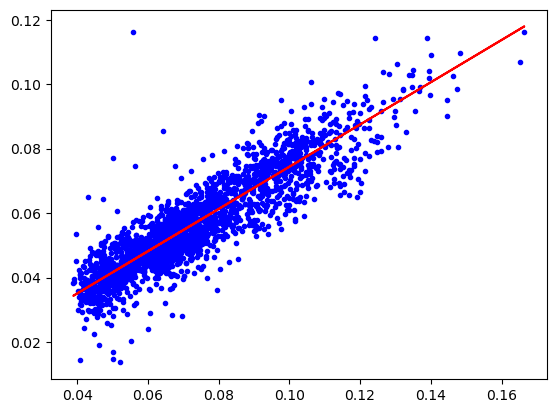

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B5_mask,NEON_B5_mask, 'b.')
ax.plot( S2_B5_mask, B5_reg[1] +B5_reg[0] * S2_B5_mask, 'r-')
plt.show()

In [96]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B5_mask,S2_B5_mask, squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B5_mask,S2_B5_mask,data_range=(S2_B5_mask.max()-S2_B5_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B5_mask,S2_B5_mask)
print (RMSE)
print (SSIM)
print (R2)

0.01951220422697916
0.7339669162360077
-0.6920586023175761


In [97]:
#B6
S2_B6=np.array(ds_S2_60m.GetRasterBand(5).ReadAsArray())
NEON_B6=np.array(ds_NEON_60m.GetRasterBand(6).ReadAsArray())

S2_B6 = np.where(S2_B6==-9999, np.nan, S2_B6)
NEON_B6 = np.where(NEON_B6==-9999, np.nan, NEON_B6)
S2_B6=S2_B6/10000

mask = ~np.isnan(S2_B6) & ~np.isnan(NEON_B6)
NEON_B6_mask = NEON_B6[mask]
S2_B6_mask = S2_B6[mask]
B6_reg = stats.theilslopes(NEON_B6_mask,S2_B6_mask, 0.90, 'joint')

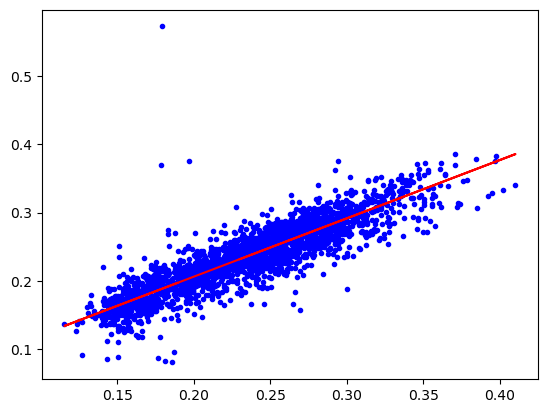

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B6_mask, NEON_B6_mask, 'b.')
ax.plot( S2_B6_mask, B6_reg[1] +B6_reg[0] * S2_B6_mask, 'r-')
plt.show()

In [99]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B6_mask,S2_B6_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B6_mask,S2_B6_mask,data_range=(S2_B6_mask.max()-S2_B6_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B6_mask,S2_B6_mask)
print (RMSE)
print (SSIM)
print (R2)

0.02569370691200031
0.7628711099434891
0.7443272827360292


In [100]:
#B7
S2_B7=np.array(ds_S2_60m.GetRasterBand(6).ReadAsArray())
NEON_B7=np.array(ds_NEON_60m.GetRasterBand(7).ReadAsArray())

S2_B7 = np.where(S2_B7==-9999, np.nan, S2_B7)
NEON_B7 = np.where(NEON_B7==-9999, np.nan, NEON_B7)
S2_B7=S2_B7/10000

mask = ~np.isnan(S2_B7) & ~np.isnan(NEON_B7)
NEON_B7_mask = NEON_B7[mask]
S2_B7_mask = S2_B7[mask]
B7_reg = stats.theilslopes(NEON_B7_mask,S2_B7_mask, 0.90, 'joint')

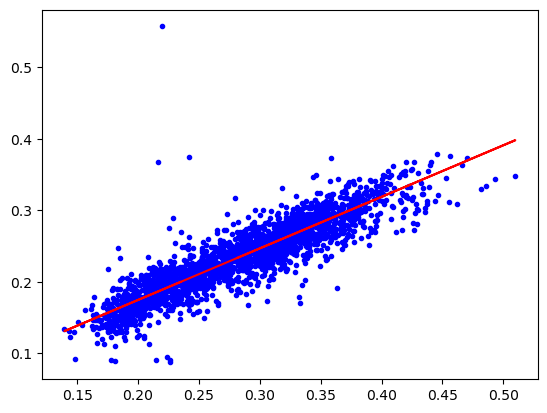

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B7_mask,NEON_B7_mask, 'b.')
ax.plot( S2_B7_mask,B7_reg[1] +B7_reg[0] * S2_B7_mask, 'r-')
plt.show()

In [102]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B7_mask,S2_B7_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B7_mask,S2_B7_mask,data_range=(S2_B7_mask.max()-S2_B7_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B7_mask,S2_B7_mask)
print (RMSE)
print (SSIM)
print (R2)

0.058175914695405534
0.76549718955592
-0.2889570010835316


In [103]:
#B8A
S2_B8A=np.array(ds_S2_60m.GetRasterBand(7).ReadAsArray())
NEON_B8A=np.array(ds_NEON_60m.GetRasterBand(9).ReadAsArray())

S2_B8A = np.where(S2_B8A==-9999, np.nan, S2_B8A)
NEON_B8A = np.where(NEON_B8A==-9999, np.nan, NEON_B8A)
S2_B8A=S2_B8A/10000

mask = ~np.isnan(S2_B8A) & ~np.isnan(NEON_B8A)
NEON_B8A_mask = NEON_B8A[mask]
S2_B8A_mask = S2_B8A[mask]
B8A_reg = stats.theilslopes(NEON_B8A_mask,S2_B8A_mask, 0.90, 'joint')

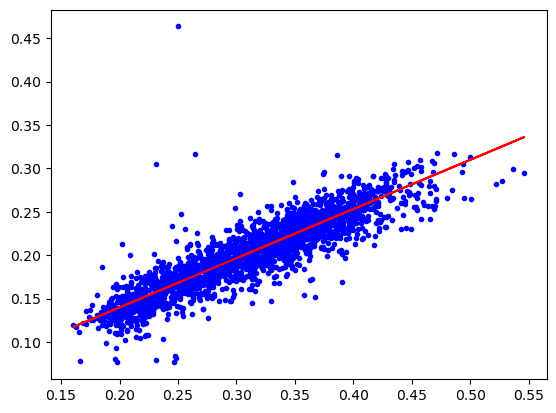

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B8A_mask,NEON_B8A_mask, 'b.')
ax.plot( S2_B8A_mask,B8A_reg[1] +B8A_reg[0] * S2_B8A_mask, 'r-')
plt.show()

In [105]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B8A_mask,S2_B8A_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B8A_mask,S2_B8A_mask,data_range=(S2_B8A_mask.max()-S2_B8A_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B8A_mask,S2_B8A_mask)
print (RMSE)
print (SSIM)
print (R2)

0.11490763731267958
0.6751548726156145
-6.306066682492057


In [106]:
#B11
S2_B11=np.array(ds_S2_60m.GetRasterBand(8).ReadAsArray())
NEON_B11=np.array(ds_NEON_60m.GetRasterBand(12).ReadAsArray())

S2_B11 = np.where(S2_B11==-9999, np.nan, S2_B11)
NEON_B11 = np.where(NEON_B11==-9999, np.nan, NEON_B11)
S2_B11=S2_B11/10000

mask = ~np.isnan(S2_B11) & ~np.isnan(NEON_B11)
NEON_B11_mask = NEON_B11[mask]
S2_B11_mask = S2_B11[mask]
B11_reg = stats.theilslopes(NEON_B11_mask,S2_B11_mask, 0.90, 'joint')

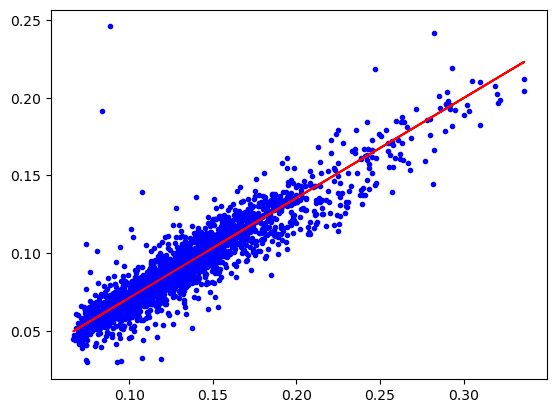

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B11_mask,NEON_B11_mask, 'b.')
ax.plot( S2_B11_mask,B11_reg[1] +B11_reg[0] * S2_B11_mask, 'r-')
plt.show()

In [108]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B11_mask, S2_B11_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B11_mask,S2_B11_mask,data_range=(S2_B11_mask.max()-S2_B11_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B11_mask,S2_B11_mask)
# R2 = r2_score(NEON_B11_mask,S2_B11_mask)
print (RMSE)
print (SSIM)
print (R2)

0.04648655414902574
0.7490846111033238
-1.437900244441134


In [109]:
print (S2_B11_mask)

[0.147  0.1523 0.1626 ... 0.0798 0.0967 0.0965]


In [110]:
print (NEON_B11_mask)

[0.12321659 0.11067757 0.10732993 ... 0.04021301 0.05326291 0.05096398]


In [111]:
# np.savetxt('S2_B11.csv',S2_B11_mask)
# np.savetxt('NEON_B11.csv',NEON_B11_mask)

In [112]:
#B12
S2_B12=np.array(ds_S2_60m.GetRasterBand(9).ReadAsArray())
NEON_B12=np.array(ds_NEON_60m.GetRasterBand(13).ReadAsArray())

S2_B12 = np.where(S2_B12==-9999, np.nan, S2_B12)
NEON_B12 = np.where(NEON_B12==-9999, np.nan, NEON_B12)
S2_B12=S2_B12/10000

mask = ~np.isnan(S2_B12) & ~np.isnan(NEON_B12)
NEON_B12_mask = NEON_B12[mask]
S2_B12_mask = S2_B12[mask]
B12_reg = stats.theilslopes(NEON_B12_mask,S2_B12_mask, 0.90, 'joint')

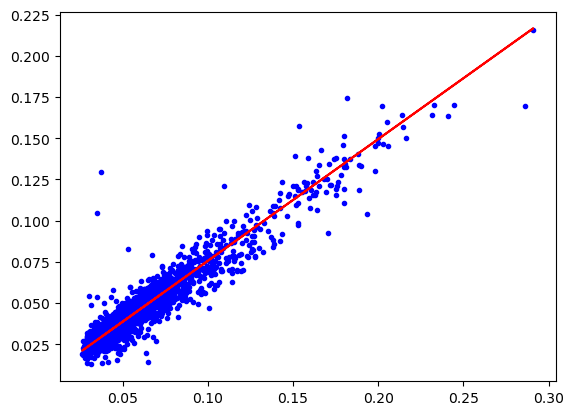

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B12_mask,NEON_B12_mask, 'b.')
ax.plot( S2_B12_mask, B12_reg[1] +B12_reg[0] * S2_B12_mask, 'r-')
plt.show()

In [114]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B12_mask,S2_B12_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B12_mask,S2_B12_mask,data_range=(S2_B12_mask.max()-S2_B12_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B12_mask,S2_B12_mask)
# R2 = r2_score(NEON_B12_mask,S2_B12_mask)
print (RMSE)
print (SSIM)
print (R2)

0.018635325942029313
0.8404614493774208
0.3745296432847567


# Normalization

In [ ]:
# S2 1-B2 2-B3 3-B4 4-B5 5-B6 6-B7 7-B8A 8-B11 9-B12

In [115]:
# ds_NEON_10m = gdal.Open(NEON_file)
ds_S2_20m = gdal.Open(S2_file)

In [116]:
def CreateGeoTiff(Name, Array, driver, NDV, 
                  GeoT, Projection, DataType):
    Array[np.isnan(Array)] = NDV
    # DataSet = driver.Create(Name, Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    # DataSet = driver.Create(Name, Array.shape[1], Array.shape[0], Array.shape[2], DataType)  ## col, row, bands
    DataSet = driver.Create(Name, Array.shape[2], Array.shape[1], Array.shape[0], DataType)  ## col, row, bands
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection.ExportToWkt() )
    # for i in range(Array.shape[2]):
    for i in range(Array.shape[0]):       
        # DataSet.GetRasterBand(i+1).WriteArray(Array[:,:,i] )
        DataSet.GetRasterBand(i+1).WriteArray(Array[i,:,:] )
        DataSet.GetRasterBand(i+1).SetNoDataValue(NDV)
    DataSet.FlushCache()
    return Name

In [117]:
prj=ds_S2_20m.GetProjection()
# print (prj)
srs=osr.SpatialReference(wkt=prj)
# print (srs)
geotransform = ds_S2_20m.GetGeoTransform()
# print (geotransform)

In [118]:
bands=ds_S2_20m.RasterCount 
width=ds_S2_20m.RasterXSize 
height=ds_S2_20m.RasterYSize 
print (bands, width, height)

9 51 570


In [119]:
S2_B= np.empty([bands, height, width], dtype=float)
# print (S22.shape)

In [120]:
# Sim_Output=np.zeros(shape=(S2_Bands,Ref_shape[0],Ref_shape[1]))

# for i in range(1, ds_NEON_10m.RasterCount + 1):
#     NEON_B[i]=np.array(ds_NEON_10m.GetRasterBand(i).ReadAsArray())
# print (NEON_B.shape)
S2_B = np.array(ds_S2_20m.ReadAsArray())
print (S2_B.shape)

(9, 570, 51)


In [122]:
# S2_B[2]=np.array(ds_NEON_10m.GetRasterBand(3).ReadAsArray())
# S2_B[1] = np.where(S2_B[1]==-9999, np.nan, S2_B[1])
S2_B[1]=B3_reg[1]*10000.0 +B3_reg[0]*S2_B[1]

# S2_B4=np.array(ds_NEON_10m.GetRasterBand(4).ReadAsArray())
# S2_B[2] = np.where(S2_B[2]==-9999, np.nan, S2_B[2])
S2_B[2]=B4_reg[1]*10000.0 +B4_reg[0]*S2_B[2]

# S2_B5=np.array(ds_NEON_10m.GetRasterBand(5).ReadAsArray())
# S2_B[3] = np.where(S2_B[3]==-9999, np.nan, S2_B[3])
S2_B[3]=B5_reg[1]*10000.0 +B5_reg[0]*S2_B[3]

# S2_B6=np.array(ds_NEON_10m.GetRasterBand(6).ReadAsArray())
# S2_B[4] = np.where(S2_B[4]==-9999, np.nan, S2_B[4])
S2_B[4]=B6_reg[1]*10000.0 +B6_reg[0]*S2_B[4]

# S2_B7=np.array(ds_NEON_10m.GetRasterBand(7).ReadAsArray())
# S2_B[5] = np.where(S2_B[5]==-9999, np.nan, S2_B[5])
S2_B[5]=B7_reg[1]*10000.0 +B7_reg[0]*S2_B[5]

# S2_B8A=np.array(ds_NEON_10m.GetRasterBand(9).ReadAsArray())
# S2_B[6] = np.where(S2_B[6]==-9999, np.nan, S2_B[6])
S2_B[6]=B8A_reg[1]*10000.0 +B8A_reg[0]*S2_B[6]

# S2_B11=np.array(ds_NEON_10m.GetRasterBand(12).ReadAsArray())
# S2_B[7] = np.where(S2_B[7]==-9999, np.nan, S2_B[7])
S2_B[7]=B11_reg[1]*10000.0 +B11_reg[0]*S2_B[7]

# S2_B12=np.array(ds_NEON_10m.GetRasterBand(13).ReadAsArray())
# S2_B[8] = np.where(S2_B[8]==-9999, np.nan, S2_B[8])
S2_B[8]=B12_reg[1]*10000.0 +B12_reg[0]*S2_B[8]

In [123]:
file_norm='F:\\neon\\normalization\\S2_20m_ABBY_norm.tif'
data_type = gdal.GDT_Float32
driver = gdal.GetDriverByName('GTiff')
CreateGeoTiff(file_norm, S2_B, driver, -9999, geotransform, srs, data_type)

'F:\\neon\\normalization\\S2_20m_ABBY_norm.tif'

# Verify the normalized result

In [131]:
## generate 20 m neon data
raster_rprj = gdal.Warp(NEON_file_20m, NEON_file, xRes=20, yRes=20, resampleAlg = "average")
raster_rprj = None

In [132]:
S2_file_20m='F:\\neon\\normalization\\S2_20m_ABBY_norm.tif'
ds_S2_20m = gdal.Open(S2_file_20m)
ds_NEON_20m = gdal.Open(NEON_file_20m)
print (ds_S2_20m.RasterCount)
print (ds_NEON_20m.RasterCount)
print (ds_S2_20m.GetDescription())
print (ds_NEON_20m.GetDescription())

9
16
F:\neon\normalization\S2_20m_ABBY_norm.tif
F:\neon\normalization\NEON_20m_ABBY.tif


In [133]:
#B3
S2_B3=np.array(ds_S2_20m.GetRasterBand(2).ReadAsArray())
NEON_B3=np.array(ds_NEON_20m.GetRasterBand(3).ReadAsArray())

S2_B3 = np.where(S2_B3==-9999, np.nan, S2_B3)
NEON_B3 = np.where(NEON_B3==-9999, np.nan, NEON_B3)
# S2_B3=S2_B3/10000


In [134]:
print (S2_B3.shape)
print (NEON_B3.shape)

(570, 51)
(571, 52)


In [137]:
# make a new S2_B3 array with the same size of NENON
# S2_B3_2=S2_B3[:NEON_B3.shape[0],:NEON_B3.shape[1]]
NEON_B3_2=NEON_B3[:S2_B3.shape[0],:S2_B3.shape[1]]

In [138]:
mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3_2)
NEON_B3_mask = NEON_B3_2[mask]
S2_B3_mask = S2_B3[mask]/10000

In [139]:
print (NEON_B3_mask)
print (NEON_B3_mask.max())

[0.06845751 0.05076365 0.0457106  ... 0.01999686 0.01320979 0.02979336]
0.16333152


In [140]:
print (S2_B3_mask)
print (S2_B3_mask.max())

[0.0561 0.0428 0.0301 ... 0.026  0.0265 0.0236]
0.1735


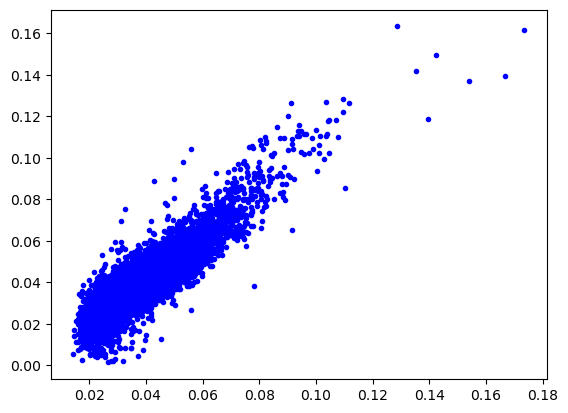

In [141]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B3_mask,NEON_B3_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [142]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B3_mask,S2_B3_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B3_mask,S2_B3_mask,data_range=(S2_B3_mask.max()-S2_B3_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B3_mask,S2_B3_mask)
print (RMSE)
print (SSIM)
print (R2)

0.005335642
0.8483131266416369
0.8189745401150585


In [143]:
# print (rmse(S2_B3_mask, NEON_B3_mask))
# print (mean_squared_error(S2_B3_mask, NEON_B3_mask, squared=False) )

In [144]:
#B4
S2_B4=np.array(ds_S2_20m.GetRasterBand(3).ReadAsArray())
NEON_B4=np.array(ds_NEON_20m.GetRasterBand(4).ReadAsArray())

S2_B4 = np.where(S2_B4==-9999, np.nan, S2_B4)
NEON_B4 = np.where(NEON_B4==-9999, np.nan, NEON_B4)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [145]:
print (S2_B4.shape)
print (NEON_B4.shape)

(570, 51)
(571, 52)


In [146]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B4_2=NEON_B4[:S2_B4.shape[0],:S2_B4.shape[1]]

In [147]:
mask = ~np.isnan(S2_B4) & ~np.isnan(NEON_B4_2)
NEON_B4_mask = NEON_B4_2[mask]
S2_B4_mask = S2_B4[mask]/10000

In [148]:
print (NEON_B4_mask)
print (NEON_B4_mask.max())

[0.07141251 0.03628144 0.01907357 ... 0.0092755  0.00623996 0.01462822]
0.16347943


In [149]:
print (S2_B4_mask)
print (S2_B4_mask.max())

[0.0506 0.0284 0.0132 ... 0.0111 0.0113 0.0114]
0.1777


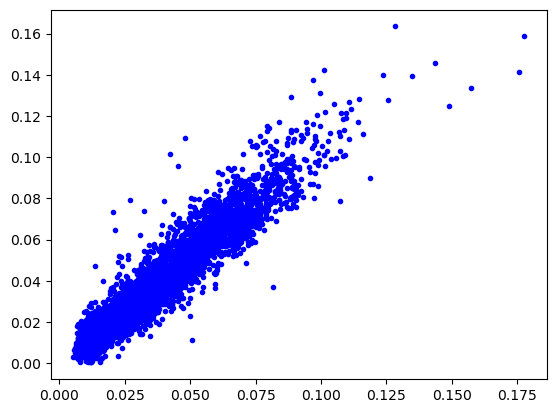

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B4_mask,NEON_B4_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [151]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B4_mask,S2_B4_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B4_mask,S2_B4_mask,data_range=(S2_B4_mask.max()-S2_B4_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B4_mask,S2_B4_mask)
print (RMSE)
print (SSIM)
print (R2)

0.00449503
0.9035482273021747
0.9217611827646988


In [152]:
#B5
S2_B5=np.array(ds_S2_20m.GetRasterBand(4).ReadAsArray())
NEON_B5=np.array(ds_NEON_20m.GetRasterBand(5).ReadAsArray())

S2_B5 = np.where(S2_B5==-9999, np.nan, S2_B5)
NEON_B5 = np.where(NEON_B5==-9999, np.nan, NEON_B5)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [153]:
print (S2_B5.shape)
print (NEON_B5.shape)

(570, 51)
(571, 52)


In [160]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B5_2=NEON_B5[:S2_B5.shape[0],:S2_B5.shape[1]]

In [161]:
mask = ~np.isnan(S2_B5) & ~np.isnan(NEON_B5_2)
NEON_B5_mask = NEON_B5_2[mask]
S2_B5_mask = S2_B5[mask]/10000

In [162]:
print (NEON_B5_mask)
print (NEON_B5_mask.max())

[0.0969548  0.07321005 0.07056975 ... 0.03086538 0.02015662 0.04482779]
0.18759295


In [163]:
print (S2_B5_mask)
print (S2_B5_mask.max())

[0.0772 0.0644 0.0492 ... 0.0399 0.0398 0.0376]
0.1652


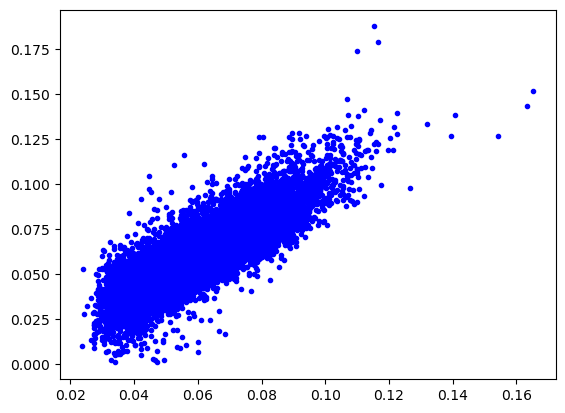

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B5_mask,NEON_B5_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [165]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B5_mask,S2_B5_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B5_mask,S2_B5_mask,data_range=(S2_B5_mask.max()-S2_B5_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B5_mask,S2_B5_mask)
print (RMSE)
print (SSIM)
print (R2)

0.008927277
0.7132701196603
0.7545362231282033


In [166]:
#B6
S2_B6=np.array(ds_S2_20m.GetRasterBand(5).ReadAsArray())
NEON_B6=np.array(ds_NEON_20m.GetRasterBand(6).ReadAsArray())

S2_B6 = np.where(S2_B6==-9999, np.nan, S2_B6)
NEON_B6 = np.where(NEON_B6==-9999, np.nan, NEON_B6)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [167]:
print (S2_B6.shape)
print (NEON_B6.shape)

(570, 51)
(571, 52)


In [168]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B6_2=NEON_B6[:S2_B6.shape[0],:S2_B6.shape[1]]

In [169]:
mask = ~np.isnan(S2_B6) & ~np.isnan(NEON_B6_2)
NEON_B6_mask = NEON_B6_2[mask]
S2_B6_mask = S2_B6[mask]/10000

In [170]:
print (NEON_B6_mask)
print (NEON_B6_mask.max())

[0.21244082 0.25519457 0.31366536 ... 0.15378441 0.11098754 0.2072202 ]
0.5728195


In [171]:
print (S2_B6_mask)
print (S2_B6_mask.max())

[0.2258 0.2433 0.2505 ... 0.1911 0.1889 0.1686]
0.4538


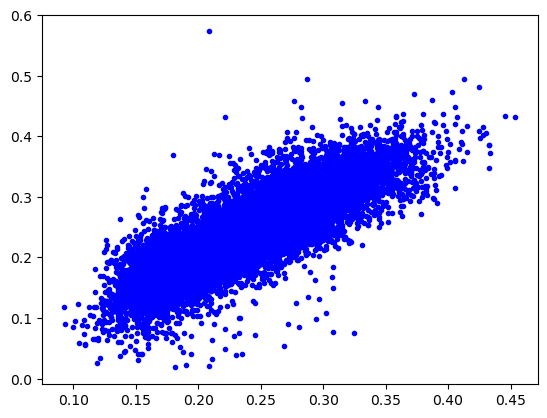

In [172]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B6_mask,NEON_B6_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [173]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B6_mask,S2_B6_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B6_mask,S2_B6_mask,data_range=(S2_B6_mask.max()-S2_B6_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B6_mask,S2_B6_mask)
print (RMSE)
print (SSIM)
print (R2)

0.032243013
0.6839774957860696
0.7341092654876016


In [174]:
#B7
S2_B7=np.array(ds_S2_20m.GetRasterBand(6).ReadAsArray())
NEON_B7=np.array(ds_NEON_20m.GetRasterBand(7).ReadAsArray())

S2_B7 = np.where(S2_B7==-9999, np.nan, S2_B7)
NEON_B7 = np.where(NEON_B7==-9999, np.nan, NEON_B7)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [175]:
print (S2_B7.shape)
print (NEON_B7.shape)

(570, 51)
(571, 52)


In [177]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B7_2=NEON_B7[:S2_B7.shape[0],:S2_B7.shape[1]]

In [178]:
mask = ~np.isnan(S2_B7) & ~np.isnan(NEON_B7_2)
NEON_B7_mask = NEON_B7_2[mask]
S2_B7_mask = S2_B7[mask]/10000

In [179]:
print (NEON_B7_mask)
print (NEON_B7_mask.max())

[0.20099455 0.2520964  0.31083134 ... 0.15792988 0.11796968 0.20956141]
0.5573273


In [180]:
print (S2_B7_mask)
print (S2_B7_mask.max())

[0.2276 0.2478 0.2458 ... 0.1907 0.1938 0.1721]
0.4607


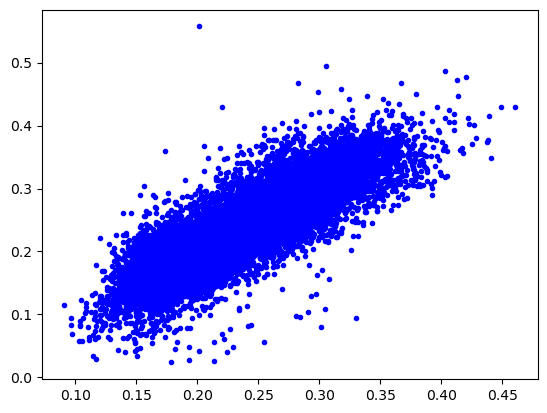

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B7_mask,NEON_B7_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [182]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B7_mask,S2_B7_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B7_mask,S2_B7_mask,data_range=(S2_B7_mask.max()-S2_B7_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B7_mask,S2_B7_mask)
print (RMSE)
print (SSIM)
print (R2)

0.031612482
0.697232517083295
0.7492573373136403


In [183]:
#B8A
S2_B8A=np.array(ds_S2_20m.GetRasterBand(7).ReadAsArray())
NEON_B8A=np.array(ds_NEON_20m.GetRasterBand(9).ReadAsArray())

S2_B8A = np.where(S2_B8A==-9999, np.nan, S2_B8A)
NEON_B8A = np.where(NEON_B8A==-9999, np.nan, NEON_B8A)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [184]:
print (S2_B8A.shape)
print (NEON_B8A.shape)

(570, 51)
(571, 52)


In [185]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B8A_2=NEON_B8A[:S2_B8A.shape[0],:S2_B8A.shape[1]]

In [186]:
mask = ~np.isnan(S2_B8A) & ~np.isnan(NEON_B8A_2)
NEON_B8A_mask = NEON_B8A_2[mask]
S2_B8A_mask = S2_B8A[mask]/10000

In [187]:
print (NEON_B8A_mask)
print (NEON_B8A_mask.max())

[0.1756063  0.21350661 0.26214704 ... 0.1355974  0.1026815  0.1782839 ]
0.46342623


In [188]:
print (S2_B8A_mask)
print (S2_B8A_mask.max())

[0.1905 0.2044 0.2126 ... 0.1652 0.1636 0.1478]
0.3763


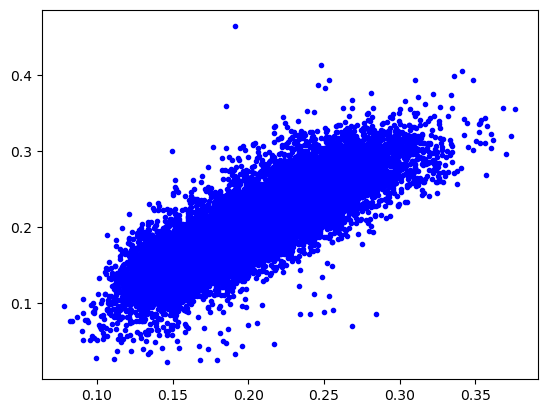

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B8A_mask,NEON_B8A_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [190]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B8A_mask,S2_B8A_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B8A_mask,S2_B8A_mask,data_range=(S2_B8A_mask.max()-S2_B8A_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B8A_mask,S2_B8A_mask)
print (RMSE)
print (SSIM)
print (R2)

0.02656803
0.686716909274765
0.7442370884720678


In [191]:
#B11
S2_B11=np.array(ds_S2_20m.GetRasterBand(8).ReadAsArray())
NEON_B11=np.array(ds_NEON_20m.GetRasterBand(12).ReadAsArray())

S2_B11 = np.where(S2_B11==-9999, np.nan, S2_B11)
NEON_B11 = np.where(NEON_B11==-9999, np.nan, NEON_B11)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [192]:
print (S2_B11.shape)
print (NEON_B11.shape)

(570, 51)
(571, 52)


In [199]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B11_2=NEON_B11[:S2_B11.shape[0],:S2_B11.shape[1]]

In [200]:
mask = ~np.isnan(S2_B11) & ~np.isnan(NEON_B11_2)
NEON_B11_mask = NEON_B11_2[mask]
S2_B11_mask = S2_B11[mask]/10000

In [201]:
print (NEON_B11_mask)
print (NEON_B11_mask.max())

[0.14947638 0.1173477  0.11677803 ... 0.05145386 0.03691084 0.06188018]
0.27853343


In [202]:
print (S2_B11_mask)
print (S2_B11_mask.max())

[0.1194 0.1079 0.0935 ... 0.0684 0.0664 0.0568]
0.2745


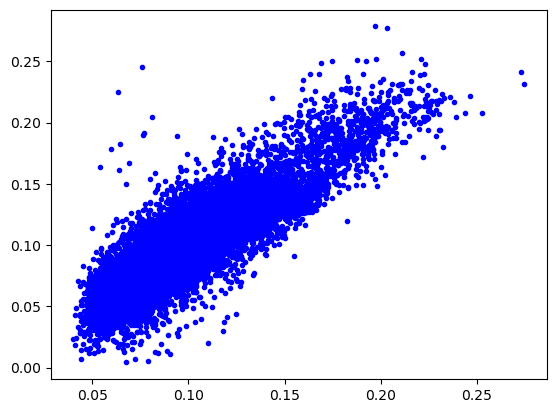

In [203]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B11_mask,NEON_B11_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [204]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B11_mask,S2_B11_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B11_mask,S2_B11_mask,data_range=(S2_B11_mask.max()-S2_B11_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B11_mask,S2_B11_mask)
print (RMSE)
print (SSIM)
print (R2)

0.015712216
0.7037248875272024
0.7989860255244712


In [205]:
#B12
S2_B12=np.array(ds_S2_20m.GetRasterBand(9).ReadAsArray())
NEON_B12=np.array(ds_NEON_20m.GetRasterBand(13).ReadAsArray())

S2_B12 = np.where(S2_B12==-9999, np.nan, S2_B12)
NEON_B12 = np.where(NEON_B12==-9999, np.nan, NEON_B12)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [206]:
print (S2_B12.shape)
print (NEON_B12.shape)

(570, 51)
(571, 52)


In [207]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

NEON_B12_2=NEON_B12[:S2_B12.shape[0],:S2_B12.shape[1]]

In [208]:
mask = ~np.isnan(S2_B12) & ~np.isnan(NEON_B12_2)
NEON_B12_mask = NEON_B12_2[mask]
S2_B12_mask = S2_B12[mask]/10000

In [209]:
print (NEON_B12_mask)
print (NEON_B12_mask.max())

[0.1125112  0.07096794 0.05482105 ... 0.02188987 0.01527343 0.02519027]
0.32578662


In [210]:
print (S2_B12_mask)
print (S2_B12_mask.max())

[0.0737 0.0639 0.0403 ... 0.0297 0.0275 0.024 ]
0.3603


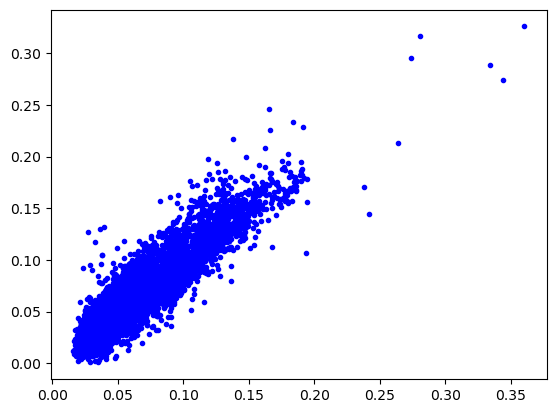

In [211]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B12_mask,NEON_B12_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [212]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B12_mask,S2_B12_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B12_mask,S2_B12_mask,data_range=(S2_B12_mask.max()-S2_B12_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B12_mask,S2_B12_mask)
print (RMSE)
print (SSIM)
print (R2)

0.010157991
0.8340968507278209
0.8617775318226356
